<a href="https://colab.research.google.com/github/JahnaviRamagiri/EVA-B2/blob/master/S5/S5_Exp4_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 4**
Target: To further increase efficiency and create a consistent model
1.	Add image augmentation 
1.1.	 Images can be slightly rotated by -7 to 7 degrees
1.2.	 Color Jitter

2.	Further Reduce Batch Size. (Batch size = 32)

Results:
1.	Parameters: 9752
2.	Best Training Accuracy: 
•	99.00 (image augmentation and batch size = 64) (17th epoch)  
•	98.94 (image augmentation and batch size = 32) (13th epoch)
•	99.06 (image augmentation and batch size = 32) (20th epoch)
3.	Best Test Accuracy: 
•	99.45 (image augmentation and batch size = 64) (17th epoch) 
•	99.49 (image augmentation and batch size = 32) (13th epoch)
•	99.53 (image augmentation and batch size = 32) (20th epoch)

Analysis:
1.	When only augmentation was performed, 9.4 or more was hit frequently but taking 20 epochs. Learning rate could experimented with to get the same result in lesser epochs.
2.	Model is under fitting as expected.
3.	Reducing batch size resulted in an accuracy of 99.49 at the 13th epoch.
4.	99.4 was hit 3 times before 15 epochs but there was a dip to 99.29 on the 15th epoch.
5.	The model can be made more consistent.


(please view edit text box by double clicking on it, if the bullets are not clear.)

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations




In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [13]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

   def forward(self, x):
                               #        Nin P K S No  Ro  J   
        x = self.convblock1(x) #        28  0 3 1 26  3   1
        x = self.convblock2(x) #        26  0 3 1 24  5   1    
        x = self.pool1(x)      #        24  0 2 2 12  6   1
        x = self.convblock3(x) #        12  0 1 1 12  6   2
        x = self.convblock4(x) #        12  0 3 1 10  10  2
        x = self.convblock5(x) #        10  0 3 1 8   14  2
        x = self.convblock6(x) #        8   1 3 1 8   18  2
        x = self.convblock7(x) #        8   1 3 1 8   22  2
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing



In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
   

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.20043691992759705 Batch_id=1874 Accuracy=93.88: 100%|██████████| 1875/1875 [00:47<00:00, 39.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.033407360315322876 Batch_id=1874 Accuracy=97.68: 100%|██████████| 1875/1875 [00:47<00:00, 39.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.036999672651290894 Batch_id=1874 Accuracy=98.26: 100%|██████████| 1875/1875 [00:48<00:00, 38.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.01141667366027832 Batch_id=1874 Accuracy=98.33: 100%|██████████| 1875/1875 [00:48<00:00, 38.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.003536507487297058 Batch_id=1874 Accuracy=98.49: 100%|██████████| 1875/1875 [00:47<00:00, 39.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.005024924874305725 Batch_id=1874 Accuracy=98.69: 100%|██████████| 1875/1875 [00:48<00:00, 38.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.05644761025905609 Batch_id=1874 Accuracy=98.70: 100%|██████████| 1875/1875 [00:48<00:00, 38.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.015929237008094788 Batch_id=1874 Accuracy=98.82: 100%|██████████| 1875/1875 [00:48<00:00, 38.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.08592286705970764 Batch_id=1874 Accuracy=98.83: 100%|██████████| 1875/1875 [00:48<00:00, 38.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.01624166965484619 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:48<00:00, 38.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.0005733668804168701 Batch_id=1874 Accuracy=98.80: 100%|██████████| 1875/1875 [00:47<00:00, 39.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.0007375478744506836 Batch_id=1874 Accuracy=98.84: 100%|██████████| 1875/1875 [00:48<00:00, 38.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.007800042629241943 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [00:48<00:00, 38.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.009702935814857483 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [00:48<00:00, 38.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.035467252135276794 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [00:48<00:00, 38.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.14279192686080933 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:47<00:00, 39.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.003612712025642395 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [00:48<00:00, 38.74it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.028313130140304565 Batch_id=1874 Accuracy=99.06: 100%|██████████| 1875/1875 [00:48<00:00, 38.83it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.0019371360540390015 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:48<00:00, 38.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.030196353793144226 Batch_id=1874 Accuracy=99.06: 100%|██████████| 1875/1875 [00:48<00:00, 38.90it/s]



Test set: Average loss: 0.0168, Accuracy: 9953/10000 (99.53%)



Text(0.5, 1.0, 'Test Accuracy')

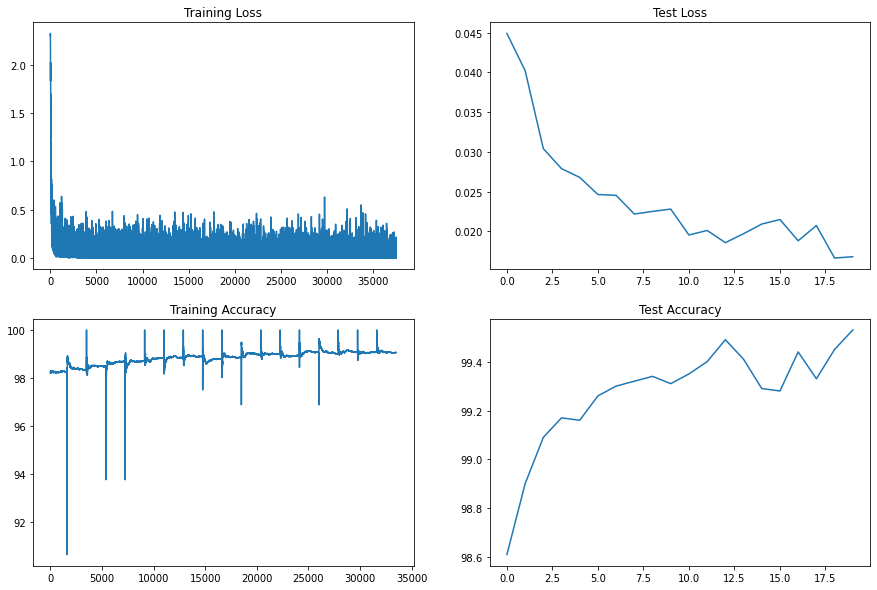

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")